# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

<b>The objective is to develop a preidction regression model to estimate the price of used cars based on relevant features which are key value parameters for the customers. Price of a used car could vary based on make, model, year, engine type, condition, fuel efficiency etc.</b>

<b>This involves identifying and quantifying key predictors by using exploratory data analysis and feature engineering methodologies. The goal is to improve pricing accuracy based on insights provided by data and help in strategic data-driven decision making.</b>

<h2>1. Data Understanding</h2>

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

We would perform below steps to understand the data and indentify any quality issues:

1. Data preprocessing
   - Cleaning the data
   - Transforming the data
   - Preparing the data for model
2. Feature Engineering
   - Identify most important features
   - Perform PCA to reduce number of relevant features
   - Check relevance of higher order feature interaction   

In [1]:
%%capture
%pip install plotly
%pip install matplotlib
%pip install pandas
%pip install seaborn
%pip install numpy
%pip install scikit-learn
%pip install vininfo
%pip install vin
%pip install pyvin
%pip install aiohttp
%pip install category_encoders

In [2]:
# import required python libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import textwrap

from vin import VIN
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

In [3]:
# Utility functions
# Wrap labels for x-axis
def wrap_labels(ax, width, n, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width, break_long_words=break_long_words))
    ax.set_xticks(np.arange(0, n, 1))
    ax.set_xticklabels(labels, rotation=0)

<h3>1.1 Understanding variables</h3>

In [4]:
vehicles = pd.read_csv('data/vehicles.csv')
vehicles.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [5]:
vehicles.tail()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy
426879,7301591129,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,NaN,coupe,NaN,wy


In [6]:
vehicles.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [7]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [8]:
# Check percentage of missing values for the columns which have more non-zero missing values
def find_missing_values_percentage(v):
    missing_values_all = v.isna().sum()
    missing_values = missing_values_all[missing_values_all > 0]
    missing_values_percentage = (missing_values / v.shape[0]) * 100
    return missing_values_percentage

missing_values_percent = find_missing_values_percentage(vehicles)
missing_values_percent

year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
dtype: float64

In [9]:
def get_unique_values(v):
    for col in v.columns:
        if v[col].isna().sum() > 0:
            unique_values = v[col].unique()
            print(f'Unique values for {col}: {unique_values}\n')

get_unique_values(vehicles) 

Unique values for year: [  nan 2014. 2010. 2020. 2017. 2013. 2012. 2016. 2019. 2011. 1992. 2018.
 2004. 2015. 2001. 2006. 1968. 2003. 2008. 2007. 2005. 1966. 2009. 1998.
 2002. 1999. 2021. 1997. 1976. 1969. 1995. 1978. 1954. 1979. 1970. 1974.
 1996. 1987. 2000. 1955. 1960. 1991. 1972. 1988. 1994. 1929. 1984. 1986.
 1989. 1973. 1946. 1933. 1958. 1937. 1985. 1957. 1953. 1942. 1963. 1977.
 1993. 1903. 1990. 1965. 1982. 1948. 1983. 1936. 1932. 1951. 1931. 1980.
 1967. 1971. 1947. 1981. 1926. 1962. 1975. 1964. 1934. 1952. 1940. 1959.
 1950. 1930. 1956. 1922. 1928. 2022. 1901. 1941. 1924. 1927. 1939. 1923.
 1949. 1961. 1935. 1918. 1900. 1938. 1913. 1916. 1943. 1925. 1921. 1915.
 1945. 1902. 1905. 1920. 1944. 1910. 1909.]

Unique values for manufacturer: [nan 'gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'buick' 'chrysler' 'volvo'
 'audi' 'infiniti' 'lincoln' 'alfa-romeo' 'subaru' 'acura' 'hyundai'
 'mercedes-benz' 'bmw' 'mitsubis

<h3>1.2 Data type transformation</h3>

In [10]:
def convert_feature_dtype():
    for col in vehicles.select_dtypes(include='object').columns:
        vehicles[col] = vehicles[col].astype('string')

convert_feature_dtype()
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  string 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  string 
 5   model         421603 non-null  string 
 6   condition     252776 non-null  string 
 7   cylinders     249202 non-null  string 
 8   fuel          423867 non-null  string 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  string 
 11  transmission  424324 non-null  string 
 12  VIN           265838 non-null  string 
 13  drive         296313 non-null  string 
 14  size          120519 non-null  string 
 15  type          334022 non-null  string 
 16  paint_color   296677 non-null  string 
 17  state         426880 non-null  string 
dtypes: f

<h2>2. Data Preparation</h2>

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

<h3>2.1 Data Wrangling</h3>

In [11]:
# Drop columns
# Drop id, as it is not useful for our analysis
# Drop size column as ~72% of the values are missing.
vehicles_df = vehicles.drop(['id', 'size'], axis=1)
vehicles_df.tail()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state
426875,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,sedan,<NA>,wy
426876,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,<NA>,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,sedan,red,wy
426877,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,<NA>,diesel,4174.0,clean,other,1GYFZFR46LF088296,<NA>,hatchback,white,wy
426878,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,sedan,silver,wy
426879,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,<NA>,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,coupe,<NA>,wy


<Axes: >

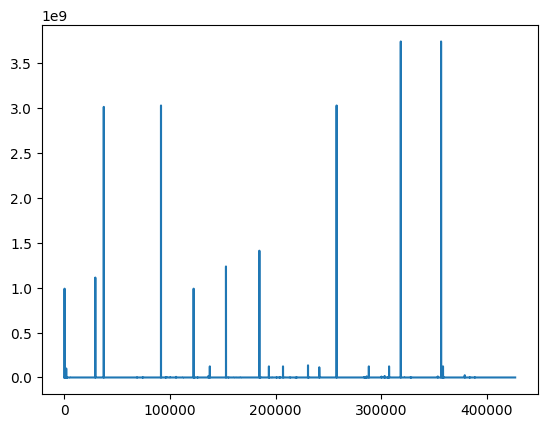

In [12]:
vehicles_df['price'].plot()

In [13]:
# Remove outliers of the price
# def remove_price_outliers_zscore():
#     mean_price = vehicles_df['price'].mean()
#     std_price = vehicles_df['price'].std()
    
#     # Calculate Z-score
#     vehicles_df['z_score'] = (vehicles_df['price'] - mean_price) / std_price
    
#     # Filter out rows with |Z_score| > 3
#     threshold = 3
#     vehicles_df_cleaned = vehicles_df[np.abs(vehicles_df['z_score']) <= threshold]
#     return vehicles_df_cleaned

# vehicles_df_cleaned = remove_price_outliers_zscore()
# vehicles_df_cleaned['price'].plot()

In [14]:
# from sklearn.ensemble import IsolationForest

# def remove_outliers_isolation_forest(df, contamination=0.1):
#     """Remove outliers using Isolation Forest."""
#     # Fit Isolation Forest
#     isolation_forest = IsolationForest(contamination=contamination, random_state=42)
#     predictions = isolation_forest.fit_predict(df.select_dtypes(include=[np.number]))
    
#     # Get mask for rows to keep (not outliers)
#     mask = predictions == 1
    
#     # Return filtered dataframe
#     return df[mask].reset_index(drop=True)

# # Example usage
# vehicles_df = remove_outliers_isolation_forest(vehicles_df, contamination=0.1)
# vehicles_df['price'].plot()

In [15]:
# Notebook crashed

# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import DBSCAN

# def remove_outliers_dbscan(df, eps=0.5, min_samples=5):
#     """Remove outliers using DBSCAN."""
#     # Standardize the data
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df)
    
#     # Fit DBSCAN
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#     clusters = dbscan.fit_predict(scaled_data)
    
#     # Get mask for rows to keep (not outliers)
#     mask = clusters != -1
    
#     # Return filtered dataframe
#     return df[mask].reset_index(drop=True)

# # Example usage
# df_clean = remove_outliers_dbscan(vehicles_df[['price']], eps=0.5, min_samples=5)
# df_clean['price'].plot()

<Axes: >

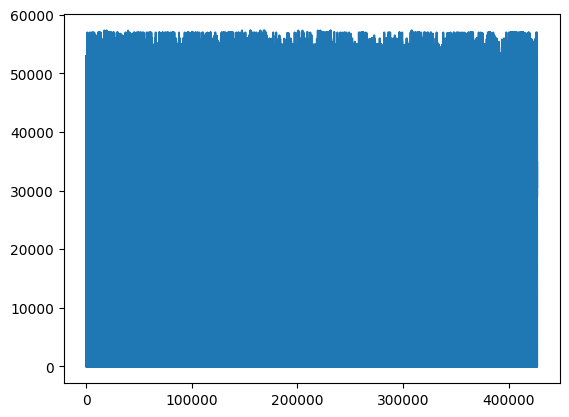

In [16]:
# Remove outliers of the price
def remove_price_outliers(vehicles_df):
    Q1 = vehicles_df['price'].quantile(0.25)
    Q3 = vehicles_df['price'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter rows within bounds
    vehicles_df = vehicles_df[(vehicles_df['price'] >= lower_bound) & (vehicles_df['price'] <= upper_bound)]
    return vehicles_df

vehicles_df = remove_price_outliers(vehicles_df)
vehicles_df['price'].plot()

In [17]:
# Apply VIN based imputation for year, make and model columns
def fill_vehicle_year(row):
    try:
        vin = VIN(row.VIN)
        return vin.model_year
    except BaseException:
        return row.year

def fill_vehicle_manufacturer(row):
    try:
        vin = VIN(row.VIN)
        return vin.make.lower()
    except BaseException:
        return row.manufacturer

def fill_vehicle_model(row):
    try:
        vin = VIN(row.VIN)
        return vin.model.lower()
    except BaseException:
        return row.model

def fill_vehicle_type(row):
    try:
        vin = VIN(row.VIN)
        # types = '|'.join(types)
        return vin.body_class.lower()
    except BaseException:
        return row.type
        
def vin_based_imputation(col):
    if col == 'year':
        vehicles_year = vehicles_df.loc[vehicles_df[col].isna() & vehicles_df['VIN'].notna()]
        vehicles_df.loc[vehicles_year.index, col] = vehicles_year.apply(fill_vehicle_year, axis=1)
    elif col == 'manufacturer':
        vehicles_make = vehicles_df.loc[vehicles_df[col].isna() & vehicles_df['VIN'].notna()]
        vehicles_df.loc[vehicles_make.index, col] = vehicles_make.apply(fill_vehicle_manufacturer, axis=1)
    elif col == 'model':
        vehicles_model = vehicles_df.loc[vehicles_df[col].isna() & vehicles_df['VIN'].notna()]
        vehicles_df.loc[vehicles_model.index, col] = vehicles_model.apply(fill_vehicle_model, axis=1)
    elif col == 'type':
        vehicles_type = vehicles_df.loc[vehicles_df[col].isna() & vehicles_df['VIN'].notna()]
        vehicles_df.loc[vehicles_type.index, col] = vehicles_type.apply(fill_vehicle_type, axis=1)
    return vehicles_df
    
vehicles_df = vin_based_imputation('year')
vehicles_df = vin_based_imputation('manufacturer')
vehicles_df = vin_based_imputation('model')
types = vehicles_df['type'].unique()
vehicles_df = vin_based_imputation('type')
vehicles_df.tail()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state
426875,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,sedan,<NA>,wy
426876,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,<NA>,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,sedan,red,wy
426877,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,<NA>,diesel,4174.0,clean,other,1GYFZFR46LF088296,<NA>,hatchback,white,wy
426878,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,sedan,silver,wy
426879,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,<NA>,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,coupe,<NA>,wy


In [18]:
# Drop rows where year is nan
vehicles_df = vehicles_df[vehicles_df['year'].notna()]
len(vehicles_df)

418522

In [19]:
# Calculate age of the car
vehicles_df = vehicles_df.reset_index(drop=True)
vehicles_df['car_age'] = 2025 - vehicles_df['year']
vehicles_df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state,car_age
0,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,3GTP1VEC4EG551563,<NA>,pickup,white,al,11.0
1,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,1GCSCSE06AZ123805,<NA>,pickup,blue,al,15.0
2,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,3GCPWCED5LG130317,<NA>,pickup,red,al,5.0
3,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,5TFRM5F17HX120972,<NA>,pickup,red,al,8.0
4,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,<NA>,rwd,truck,black,al,12.0


In [20]:
# Data fix for model value=1500 based on manufactures and model
def fix_car_model():
    model_ram_df = vehicles_df[(vehicles_df['manufacturer']== 'ram') & (vehicles_df['model']== '1500')]
    model_gmc_df = vehicles_df[(vehicles_df['manufacturer']== 'gmc') & (vehicles_df['model']== '1500')]
    model_chevrolet_df = vehicles_df[(vehicles_df['manufacturer']== 'chevrolet') & (vehicles_df['model']== '1500')]
    # model_dodge_df = vehicles_df[(vehicles_df['manufacturer']== 'dodge') & (vehicles_df['model']== '1500')]

    vehicles_df.loc[model_ram_df.index, 'model'] = '1500 laramie'
    vehicles_df.loc[model_gmc_df.index, 'model'] = 'sierra 1500'
    vehicles_df.loc[model_chevrolet_df.index, 'model'] = 'silverado 1500'
    return vehicles_df

vehicles_df = fix_car_model()

In [21]:
vehicles['type'].unique()

<StringArray>
[         <NA>,      'pickup',       'truck',       'other',       'coupe',
         'SUV',   'hatchback',    'mini-van',       'sedan',     'offroad',
         'bus',         'van', 'convertible',       'wagon']
Length: 14, dtype: string

In [22]:
# Convert year from float to integer
vehicles_df['year'] = vehicles_df['year'].astype('int64')
vehicles_df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state,car_age
0,auburn,33590,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,3GTP1VEC4EG551563,<NA>,pickup,white,al,11.0
1,auburn,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,1GCSCSE06AZ123805,<NA>,pickup,blue,al,15.0
2,auburn,39590,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,3GCPWCED5LG130317,<NA>,pickup,red,al,5.0
3,auburn,30990,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,5TFRM5F17HX120972,<NA>,pickup,red,al,8.0
4,auburn,15000,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,<NA>,rwd,truck,black,al,12.0


In [23]:
# Fix car type data
def fix_car_type():
    type_sport_df = vehicles_df[vehicles_df['type']== 'sport utility vehicle (suv)/multi-purpose vehicle (mpv)']
    type_cuv_df = vehicles_df[vehicles_df['type']== 'crossover utility vehicle (cuv)']
    type_van_df = vehicles_df[vehicles_df['type']== 'step van / walk-in van']
    type_chasis_df = vehicles_df[vehicles_df['type']== 'incomplete - chassis cab (single cab)']
    type_sut_df = vehicles_df[vehicles_df['type']== 'sport utility truck (sut)']
    type_hatchback_df = vehicles_df[vehicles_df['type']== 'hatchback/liftback/notchback']
    type_minivan_df = vehicles_df[vehicles_df['type']== 'minivan']
    type_sedan_df = vehicles_df[vehicles_df['type']== 'sedan/saloon']

    vehicles_df.loc[type_sport_df.index, 'type'] = 'SUV'
    vehicles_df.loc[type_cuv_df.index, 'type'] = 'CUV'
    vehicles_df.loc[type_van_df.index, 'type'] = 'van'
    vehicles_df.loc[type_chasis_df.index, 'type'] = 'chassis cab'
    vehicles_df.loc[type_sut_df.index, 'type'] = 'SUT'
    vehicles_df.loc[type_hatchback_df.index, 'type'] = 'hatchback'
    vehicles_df.loc[type_minivan_df.index, 'type'] = 'mini-van'
    vehicles_df.loc[type_sedan_df.index, 'type'] = 'sedan'
    return vehicles_df

vehicles_df = fix_car_type()
vehicles_df['type'].value_counts()

type
sedan                    92089
SUV                      84730
pickup                   48066
truck                    33325
other                    21462
coupe                    19208
hatchback                17541
wagon                    10919
van                       8541
convertible               7422
mini-van                  5701
cargo van                  688
offroad                    602
bus                        515
CUV                        350
convertible/cabriolet      274
truck-tractor               75
SUT                         59
fire apparatus              36
roadster                    16
chassis cab                  1
Name: count, dtype: Int64

<h3>2.2 Data Visualization</h3>

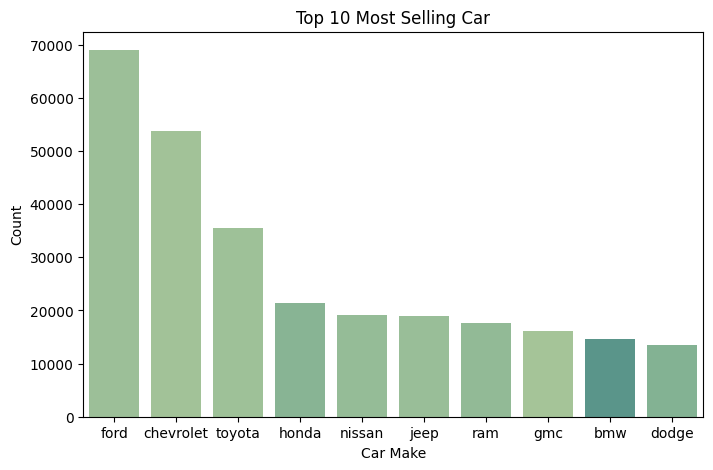

<Figure size 640x480 with 0 Axes>

In [24]:
# Top 10 selling cars
top10 = vehicles_df['manufacturer'].value_counts()[:10]

# Create a count plot to visualize the top 10 car
plt.figure(figsize=(8, 5))
sns.countplot(x='manufacturer', data=vehicles_df, order=top10.index, palette='crest', hue='manufacturer')

# Set labels and title for the plot
plt.xlabel('Car Make')
plt.ylabel('Count')
plt.title('Top 10 Most Selling Car')

# Display the plot
plt.show()
plt.savefig('images/top10_selling_car.png')

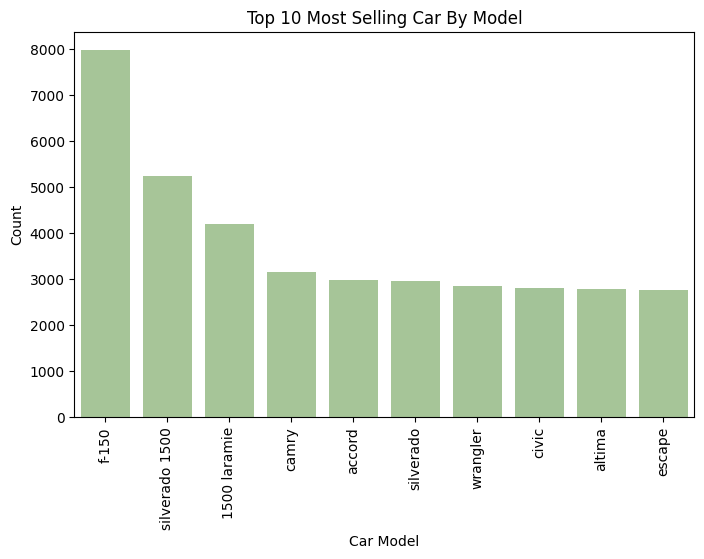

<Figure size 640x480 with 0 Axes>

In [25]:
# Top 10 selling cars by model
top10model = vehicles_df['model'].value_counts()[:10]

# Create a count plot to visualize the top 10 car
plt.figure(figsize=(8, 5))
sns.countplot(x='model', data=vehicles_df, order=top10model.index, palette='crest', hue='model')

# Set labels and title for the plot
plt.xlabel('Car Model')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Top 10 Most Selling Car By Model')

# Display the plot
plt.show()
plt.savefig('images/top10_selling_car_by_model.png')

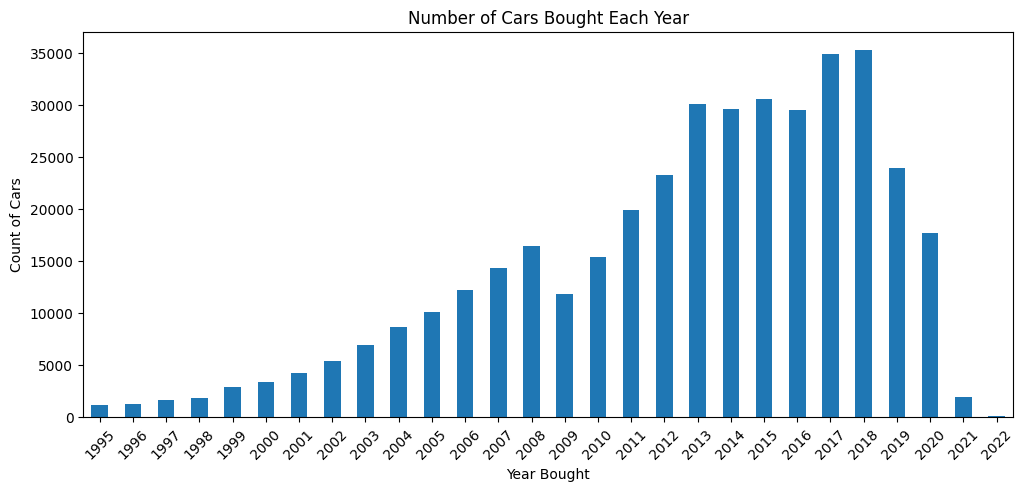

In [26]:
# Bar plot visualization for Number of Cars Bought Each Year During Last 25 Years
# Set the figure size for the plot
plt.figure(figsize=(12, 5))

# Group the data by the 'Year' column and count the number of occurrences for each year
yearly_counts = vehicles_df[vehicles_df['year'] >= 1995].groupby('year').count()['manufacturer']
yearly_counts

# Create a bar plot to visualize the count of cars bought in each year
yearly_counts.plot(kind='bar')

# Rotate the x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45)

# Set labels and title for the plot
plt.xlabel('Year Bought')
plt.ylabel('Count of Cars')
plt.title('Number of Cars Bought Each Year')

# Display and save the plot
plt.savefig('images/top10_selling_car_by_year.png')
plt.show()

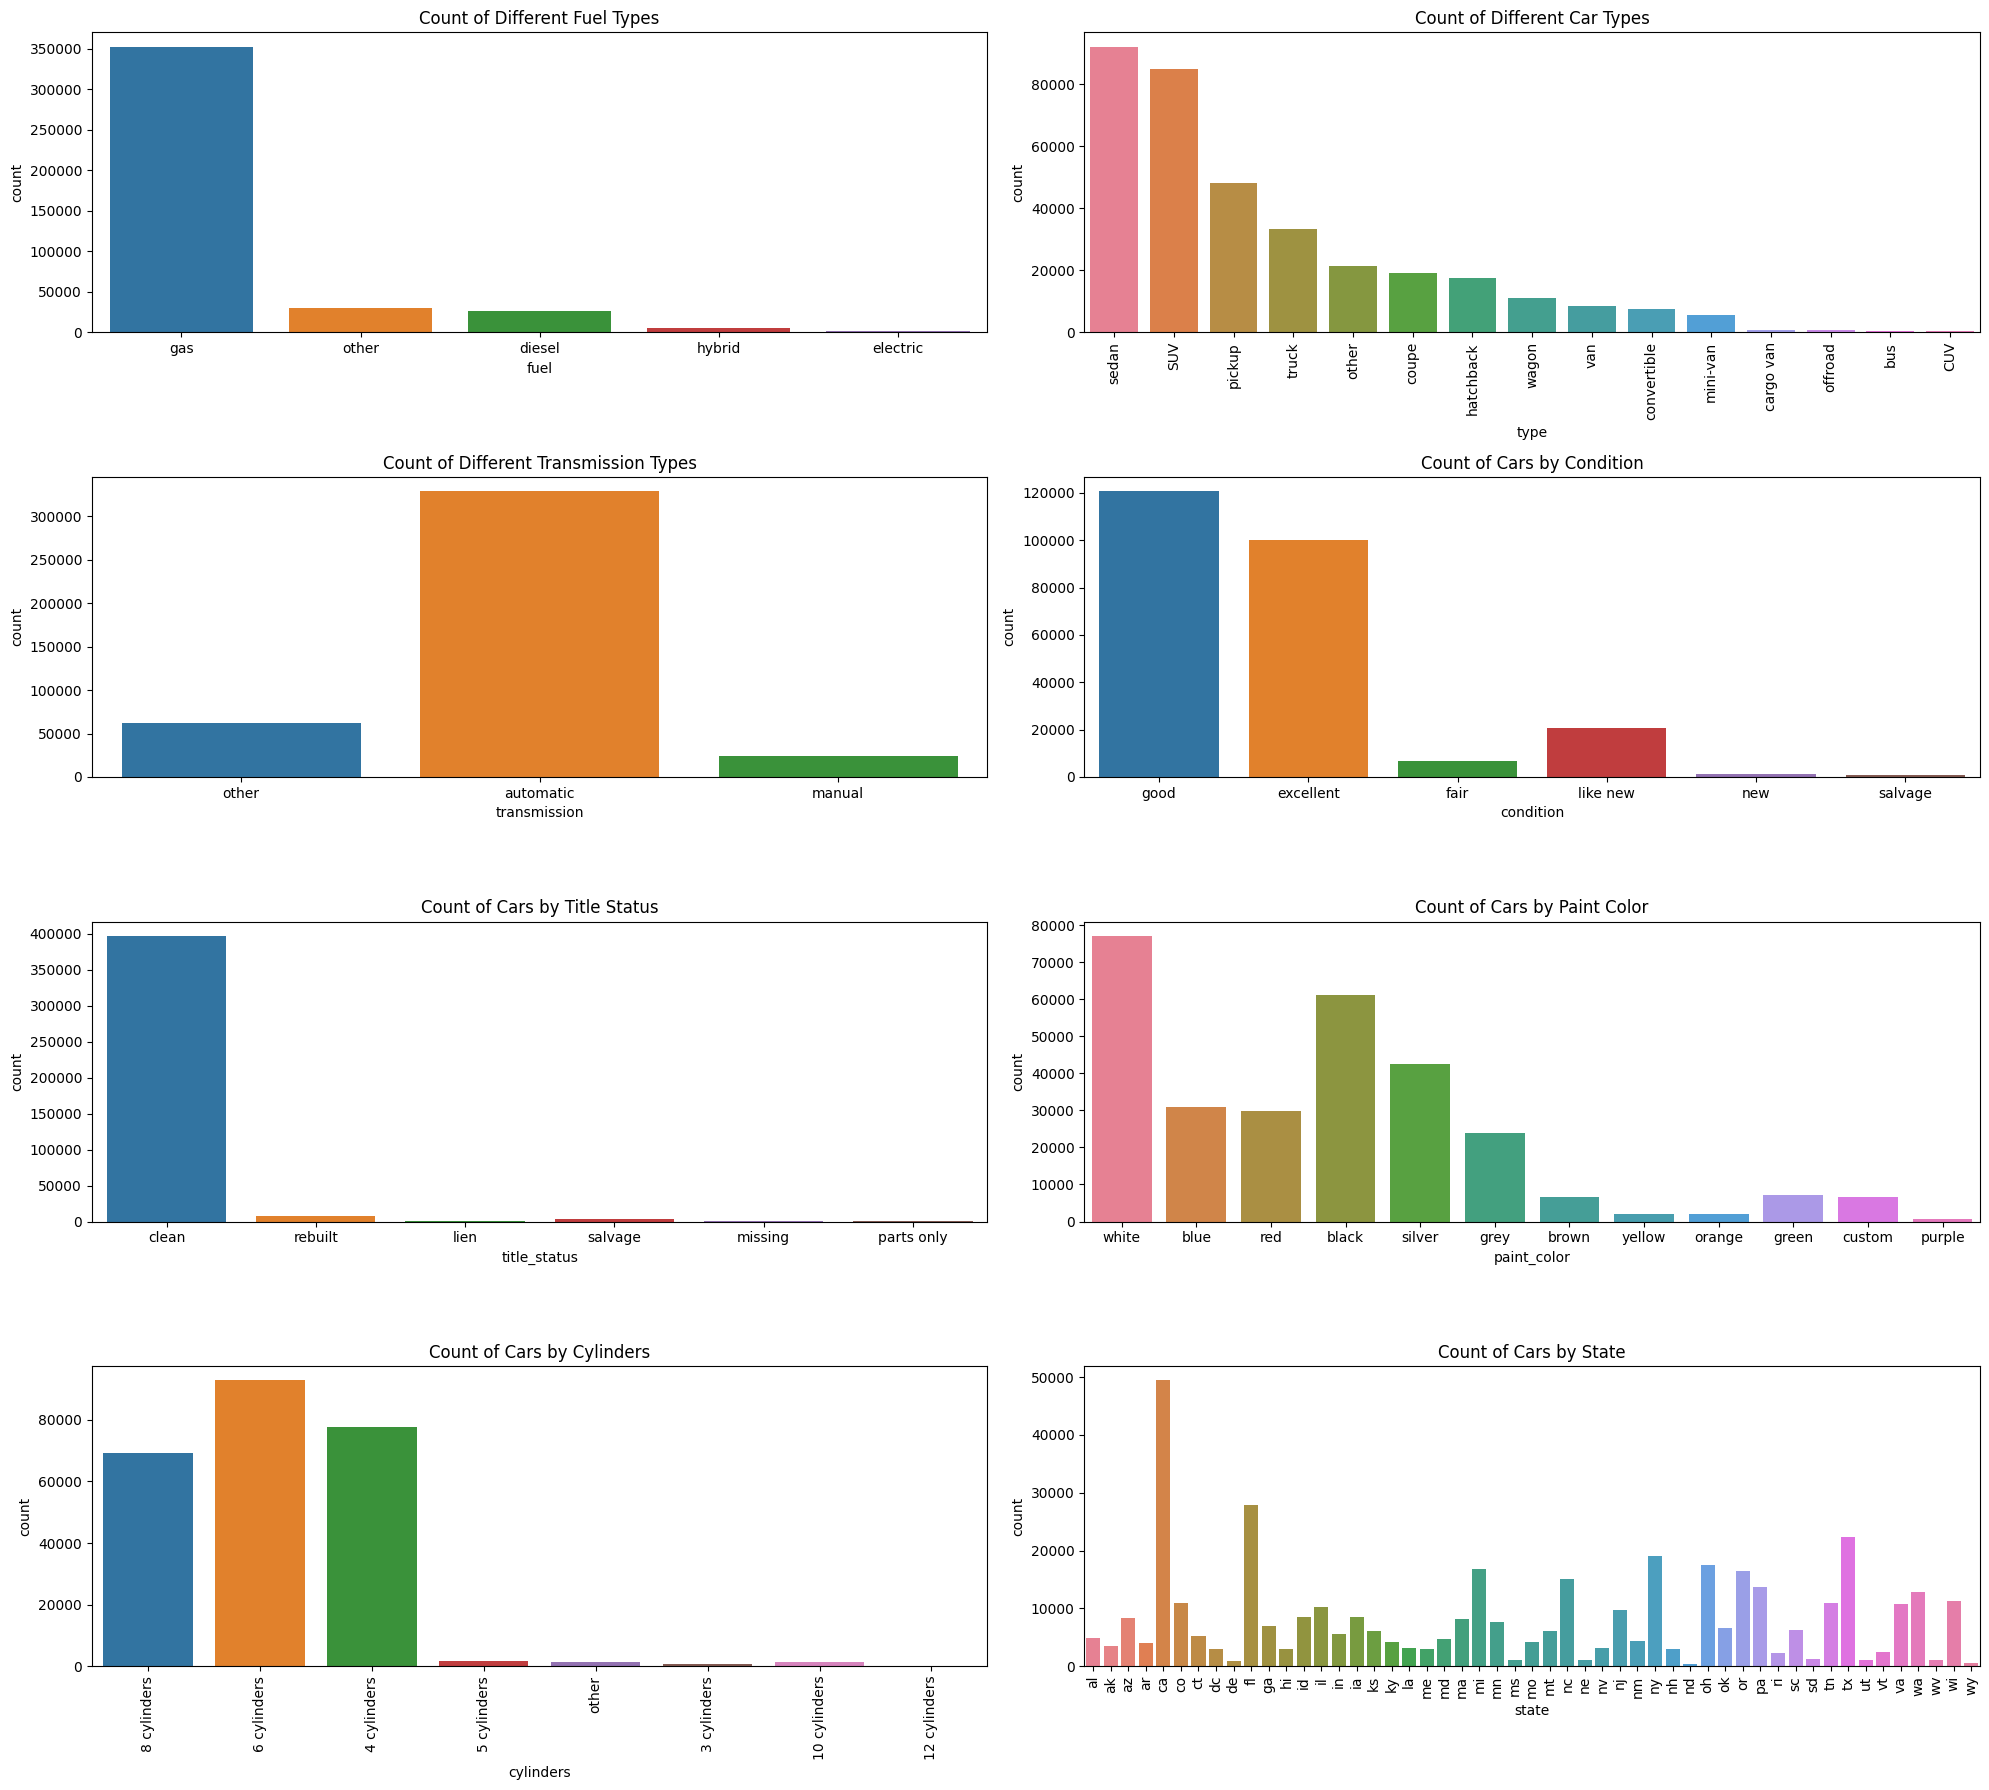

In [27]:
# Count plot visualization code for Categorical Variable
# Create a 4x2 subplot
plt.figure(figsize=(20,18))

# Subplot 1: Count of different Fuel Types
plt.subplot(4,2,1)
sns.countplot(data=vehicles_df, x='fuel', hue='fuel')
plt.title("Count of Different Fuel Types")

# Subplot 2: Count of different Car Types
plt.subplot(4,2,2)
type_df = vehicles_df['type'].value_counts()[:15].reset_index()
ax = sns.barplot(data=type_df, x='type', y='count', hue='type')
wrap_labels(ax, 10, len(type_df))
plt.title("Count of Different Car Types")
plt.xticks(rotation=90)

# Subplot 3: Count of different Transmission Types
plt.subplot(4,2,3)
sns.countplot(data=vehicles_df, x='transmission', hue='transmission')
plt.title("Count of Different Transmission Types")

# Subplot 4: Count Car Condition
plt.subplot(4,2,4)
sns.countplot(data=vehicles_df, x='condition', hue='condition')
plt.title("Count of Cars by Condition")

# Subplot 5: Count by title status
plt.subplot(4,2,5)
sns.countplot(data=vehicles_df, x='title_status', hue='title_status')
plt.title("Count of Cars by Title Status")

# Subplot 6: Count by Paint Color
plt.subplot(4,2,6)
sns.countplot(data=vehicles_df, x='paint_color', hue='paint_color')
plt.title("Count of Cars by Paint Color")

# Subplot 7: Count by Cylinders
plt.subplot(4,2,7)
sns.countplot(data=vehicles_df, x='cylinders', hue='cylinders')
plt.title("Count of Cars by Cylinders")
plt.xticks(rotation=90)

# Subplot 8: Count by state
plt.subplot(4,2,8)
sns.countplot(data=vehicles_df, x='state', hue='state')
plt.title("Count of Cars by State")
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.savefig('images/count_plot_by_category_features.png')
plt.show()

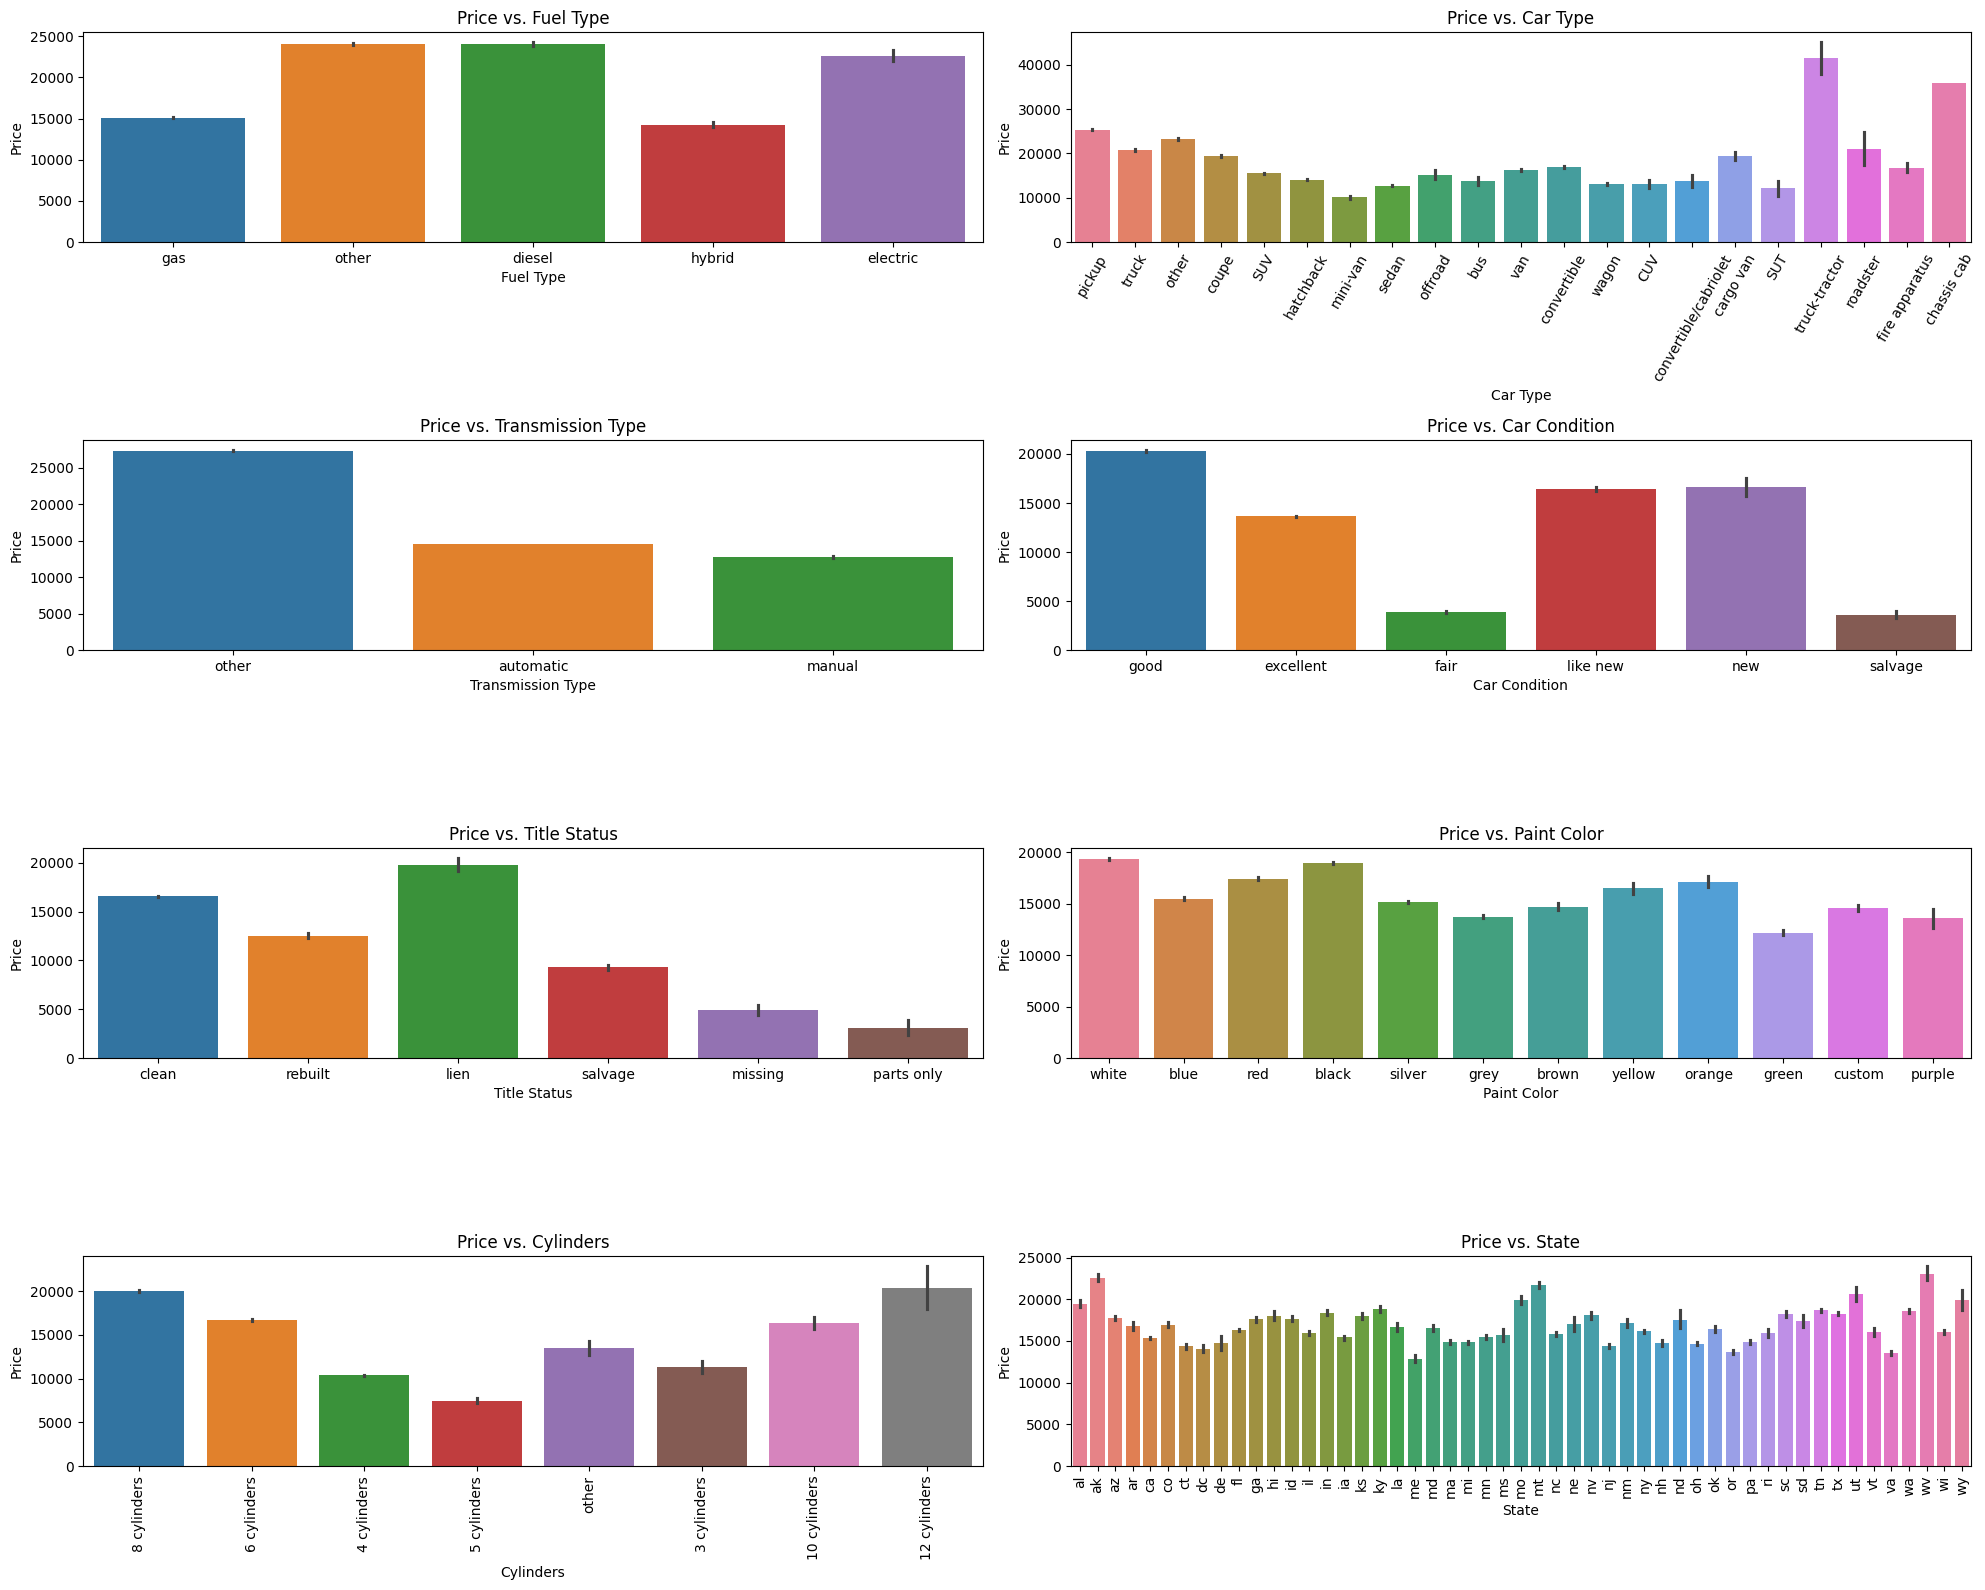

In [28]:
# Barplot visualization code for categorical variable vs target variable
# Create a 4x2 subplot
plt.figure(figsize=(20,16))

# Subplot 1: Barplot for Price vs. Fuel Type
plt.subplot(4,2,1)
sns.barplot(data=vehicles_df, x='fuel', y='price', hue='fuel')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.title('Price vs. Fuel Type')

# Subplot 2: Barplot for Price vs. Seller_Type
plt.subplot(4,2,2)
type_df = vehicles_df['type'].value_counts()
ax = sns.barplot(data=vehicles_df, x='type', y='price', hue='type')
wrap_labels(ax, 20, len(type_df))
plt.xticks(rotation=60)
plt.xlabel('Car Type')
plt.ylabel('Price')
plt.title('Price vs. Car Type')

# Subplot 3: Barplot for Price vs. Transmission
plt.subplot(4,2,3)
sns.barplot(data=vehicles_df, x='transmission', y='price', hue='transmission')
plt.xlabel('Transmission Type')
plt.ylabel('Price')
plt.title('Price vs. Transmission Type')

# Subplot 4: Barplot for Price vs. Condition
plt.subplot(4,2,4)
sns.barplot(data=vehicles_df, x='condition', y='price', hue='condition')
plt.xlabel('Car Condition')
plt.ylabel('Price')
plt.title('Price vs. Car Condition')

# Subplot 5: Count by title status
plt.subplot(4,2,5)
sns.barplot(data=vehicles_df, x='title_status', y='price', hue='title_status')
plt.xlabel('Title Status')
plt.ylabel('Price')
plt.title("Price vs. Title Status")

# Subplot 6: Count by Paint Color
plt.subplot(4,2,6)
sns.barplot(data=vehicles_df, x='paint_color', y='price', hue='paint_color')
plt.xlabel('Paint Color')
plt.ylabel('Price')
plt.title("Price vs. Paint Color")

# Subplot 7: Count by Cylinders
plt.subplot(4,2,7)
sns.barplot(data=vehicles_df, x='cylinders', y='price', hue='cylinders')
plt.xlabel('Cylinders')
plt.ylabel('Price')
plt.title("Price vs. Cylinders")
plt.xticks(rotation=90)

# Subplot 8: Count by state
plt.subplot(4,2,8)
sns.barplot(data=vehicles_df, x='state', y='price', hue='state')
plt.xlabel('State')
plt.ylabel('Price')
plt.title("Price vs. State")
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.savefig('images/price_vs_category_features.png')
plt.show()

<h3>2.3 Data Cleaning/Transformation</h3>

In [29]:
# Apply KNN Imputation for price column
def apply_KNNImputer():
    vehicles_df['price_impute'] = vehicles_df['price'].replace(0, np.nan)
    print(vehicles_df.shape)
    print(vehicles_df['price_impute'].isna().sum())
    imputer = KNNImputer(n_neighbors=5)
    vehicles_df['price_impute'] = imputer.fit_transform(vehicles_df[['odometer', 'year', 'price']])
    return vehicles_df

vehicles_df = apply_KNNImputer()
print(vehicles_df.shape)
print(vehicles_df['price_impute'].isna().sum())

(418522, 18)
32878
(418522, 18)
0


In [30]:
v_df = vehicles_df.copy()

In [31]:
len(v_df[v_df['price_impute'] == 0])

1919

In [32]:
v_df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,type,paint_color,state,car_age,price_impute
0,auburn,33590,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,3GTP1VEC4EG551563,<NA>,pickup,white,al,11.0,57923.0
1,auburn,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,1GCSCSE06AZ123805,<NA>,pickup,blue,al,15.0,71229.0
2,auburn,39590,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,3GCPWCED5LG130317,<NA>,pickup,red,al,5.0,19160.0
3,auburn,30990,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,5TFRM5F17HX120972,<NA>,pickup,red,al,8.0,41124.0
4,auburn,15000,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,<NA>,rwd,truck,black,al,12.0,128000.0


In [33]:
# # Encoding condition feature based on target column
def encode_cat_features(v, feature, target):
    # vehicles_price_df = v[v['price'] != 0]
    X = v[feature]
    y = v[target]
    
    # Initialize James-Stein Encoder
    encoder = JamesSteinEncoder(
        cols=[feature], 
        return_df=True, 
        handle_missing=True)
    
    # Fit and transform the data
    X_encoded = encoder.fit_transform(X, y)
    v.loc[X_encoded.index, f'{feature}_encoded'] = X_encoded[feature] 
    v[f'{feature}_encoded'].unique()
    return v

In [34]:
v_df = encode_cat_features(v_df, 'region', 'price_impute')
v_df = encode_cat_features(v_df, 'manufacturer', 'price_impute')
v_df = encode_cat_features(v_df, 'model', 'price_impute')
v_df = encode_cat_features(v_df, 'condition', 'price_impute')
v_df = encode_cat_features(v_df, 'cylinders', 'price_impute')
v_df = encode_cat_features(v_df, 'fuel', 'price_impute')
v_df = encode_cat_features(v_df, 'title_status', 'price_impute')
v_df = encode_cat_features(v_df, 'transmission', 'price_impute')
v_df = encode_cat_features(v_df, 'type', 'price_impute')
v_df = encode_cat_features(v_df, 'drive', 'price_impute')
v_df = encode_cat_features(v_df, 'paint_color', 'price_impute')
v_df = encode_cat_features(v_df, 'state', 'price_impute')

In [35]:
# Apply KNNImputer imputation for odometer
def apply_KNNImputer_odometer(col):
    imputer = KNNImputer(n_neighbors=10)
    v_df[col] = imputer.fit_transform(v_df[['year', 'type_encoded', 'fuel_encoded']])
    return v_df

v_df = apply_KNNImputer_odometer('odometer')

In [36]:
# Apply KNNImputer imputation for cylinders
# def apply_KNNImputer_cylinders(col):
#     imputer = KNNImputer(n_neighbors=10)
#     v_df[f'{col}_encoded'] = imputer.fit_transform(v_df[['manufacturer', 'year', 'model', 'fuel']])
#     return v_df

# v_df = apply_KNNImputer_general('cylinders')

In [37]:
v_df.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'type', 'paint_color', 'state', 'car_age', 'price_impute',
       'region_encoded', 'manufacturer_encoded', 'model_encoded',
       'condition_encoded', 'cylinders_encoded', 'fuel_encoded',
       'title_status_encoded', 'transmission_encoded', 'type_encoded',
       'drive_encoded', 'paint_color_encoded', 'state_encoded'],
      dtype='object')

In [38]:
missing_values_percent = find_missing_values_percentage(v_df)
missing_values_percent

manufacturer     2.726738
model            0.857780
condition       40.301824
cylinders       41.499133
fuel             0.674039
title_status     1.897152
transmission     0.578464
VIN             37.977454
drive           30.722638
type            15.985301
paint_color     30.498755
dtype: float64

In [40]:
cols = ['price', 'region', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'title_status', 'transmission', 'VIN',
       'drive', 'type', 'paint_color', 'state']

v_df_clean = v_df.drop(cols, axis=1)
v_df_clean.head()

missing_values_percent = find_missing_values_percentage(v_df_clean)
missing_values_percent

Series([], dtype: float64)

In [41]:
vehicles_df.info()
# price KNNIMputation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418522 entries, 0 to 418521
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        418522 non-null  string 
 1   price         418522 non-null  int64  
 2   year          418522 non-null  int64  
 3   manufacturer  407110 non-null  string 
 4   model         414932 non-null  string 
 5   condition     249850 non-null  string 
 6   cylinders     244839 non-null  string 
 7   fuel          415701 non-null  string 
 8   odometer      414269 non-null  float64
 9   title_status  410582 non-null  string 
 10  transmission  416101 non-null  string 
 11  VIN           259578 non-null  string 
 12  drive         289941 non-null  string 
 13  type          351620 non-null  string 
 14  paint_color   290878 non-null  string 
 15  state         418522 non-null  string 
 16  car_age       418522 non-null  float64
 17  price_impute  418522 non-null  float64
dtypes: f

In [ ]:
v_df_clean.head()

### 3. Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### 4. Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### 5. Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.